In [14]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import datetime
import scipy.stats as stats

#graphing
import matplotlib.pyplot as plt
#stats
import statsmodels.api as sm
from statsmodels.base.model import GenericLikelihoodModel

#import testing
import sys
sys.path.append("../")
import selection_tests

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
class DiscreteOutcomes(GenericLikelihoodModel):
    
    def __init__(self, *args,ols=False, **kwargs):
        super(DiscreteOutcomes,self).__init__(*args,**kwargs)

    def loglikeobs(self, params):
        y = self.endog
        x = self.exog
        present_bias = x[:,0]
        future_bias = x[:,1]
        likelihood = np.ones(y.shape[0])
        if len(params) == 4:
            likelihood = (params[0]*present_bias*(1-future_bias) +
                      params[1]*(1-present_bias)*future_bias + 
                      params[2]*(future_bias)*(present_bias) +
                      params[3]*(1-present_bias)*(1-future_bias))
        if len(params) == 2:
            likelihood = (params[0]*present_bias*(1-future_bias) +
                      params[1]*((1-present_bias)*future_bias + 
                      (future_bias)*(present_bias) +
                      (1-present_bias)*(1-future_bias)))
                          
        return np.log(likelihood)

def return_params(xn):
    xn = np.array(xn)
    present_bias = xn[:,0]
    future_bias = xn[:,1]
    return np.array([(present_bias*(1-future_bias)).mean(),
            ((1-present_bias)*future_bias).mean(), 
            ((future_bias)*(present_bias)).mean(),
            ((1-present_bias)*(1-future_bias)).mean()])


data = pd.read_csv('biases.csv',index_col=0)
params = np.array([19/64,19/64,18/64,8/64])
print(return_params(data[['present_bias','future_bias']]))
model1_deriv = DiscreteOutcomes(data['client'],data[['present_bias','future_bias']])
ll1 = model1_deriv.loglikeobs(params)
grad1 =  model1_deriv.score_obs(params)
hess1 = model1_deriv.hessian(params)
print(ll1.shape)

[0.75       0.15       0.08333333 0.01666667]
(60,)


In [16]:
def setup_test(yn,xn,return_model=False,test1=True):
    # model 1 grad, etc.
    params1 = return_params(xn)
    if not test1:
        params1 = np.array([51/100,49/100])
    model1_deriv = DiscreteOutcomes(yn,xn)
    ll1 = model1_deriv.loglikeobs(params1)
    grad1 =  model1_deriv.score_obs(params1)    
    hess1 = model1_deriv.hessian(params1)

    #19/64, 19/64, 18/64, 8/64
    params2 = np.array([19/64,19/64,18/64,8/64])
    model2_deriv = DiscreteOutcomes(yn,xn)
    ll2 = model2_deriv.loglikeobs(params2)
    grad2 =  model2_deriv.score_obs(params2)    
    hess2 = model2_deriv.hessian(params2)
    
    return ll1,grad1,hess1,params1,ll2,grad2,hess2,params2



In [17]:
setup_test1 = lambda yn,xn: setup_test(yn,xn,test1=False)

print(selection_tests.test_table(data['client'], data[['present_bias','future_bias']],
                                 setup_test))

regular: test, llr, omega ----
4.251283219590945 27.463328859966698 0.8339836061412603
---- 
\begin{center}
\begin{tabular}{ccccc}
\toprule
\textbf{Version} & \textbf{Result} & \textbf{90 \% CI} & \textbf{95 \% CI} & \textbf{99 \% CI} \\ \midrule
Shi (2015) & H0 & [1.787, 6.715] & [-0.014, 8.517] & [-26.911, 35.413] \\
Classical & H1 & [2.606, 5.896] & [2.292, 6.210] & [1.675, 6.827] \\
Bootstrap & H1 & [2.102, 7.022] & [1.813, 7.694] & [1.345, 9.500] \\
\bottomrule
\end{tabular}
\end{center}
None


../selection_tests.py:141: ComplexWarning: Casting complex values to real discards the imaginary part
  print('Shi (2015) & H%s & [%.3f, %.3f] & [%.3f, %.3f] & [%.3f, %.3f] \\\\'%(result_shi,
../selection_tests.py:149: ComplexWarning: Casting complex values to real discards the imaginary part
  print('Bootstrap & H%s & [%.3f, %.3f] & [%.3f, %.3f] & [%.3f, %.3f] \\\\'%(result_boot,


In [18]:
print(selection_tests.test_table(data['client'],data[['present_bias','future_bias']],
                                 setup_test1))

regular: test, llr, omega ----
39.693457727478176 33.00122658040044 0.10733355760860354
---- 
\begin{center}
\begin{tabular}{ccccc}
\toprule
\textbf{Version} & \textbf{Result} & \textbf{90 \% CI} & \textbf{95 \% CI} & \textbf{99 \% CI} \\ \midrule
Shi (2015) & H1 & [38.236, 43.598] & [38.215, 43.618] & [36.791, 45.043] \\
Classical & H1 & [38.048, 41.338] & [37.734, 41.652] & [37.117, 42.269] \\
Bootstrap & H1 & [25.378, 327.034] & [25.137, 357.371] & [22.481, 405.740] \\
\bottomrule
\end{tabular}
\end{center}
None


../selection_tests.py:141: ComplexWarning: Casting complex values to real discards the imaginary part
  print('Shi (2015) & H%s & [%.3f, %.3f] & [%.3f, %.3f] & [%.3f, %.3f] \\\\'%(result_shi,
../selection_tests.py:149: ComplexWarning: Casting complex values to real discards the imaginary part
  print('Bootstrap & H%s & [%.3f, %.3f] & [%.3f, %.3f] & [%.3f, %.3f] \\\\'%(result_boot,


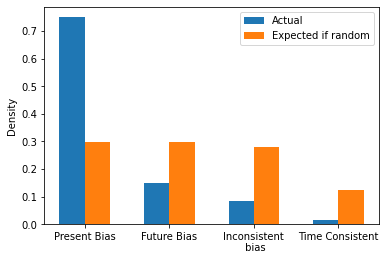

In [19]:
labels = ["Present Bias", "Future Bias", "Inconsistent\n bias","Time Consistent"]

# Position of bars on x-axis
ind = np.arange(len(labels))

# Width of a bar 
width = 0.3       

# Plotting
plt.bar(ind, return_params(data[['present_bias','future_bias']]) , width, label='Actual')
plt.bar(ind + width, [19/64,19/64,18/64,8/64], width, label='Expected if random')

plt.ylabel('Density')
# First argument - A list of positions at which ticks should be placed
# Second argument -  A list of labels to place at the given locations
plt.xticks(ind + width / 2, labels)

# Finding the best position for legends and putting it
plt.legend(loc='best')
plt.savefig('time_consist.png',dpi=500)
plt.show()